In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import pickle
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
tf.__version__

'2.1.0'

In [3]:
bus_id_encoder     = pickle.load(open("./out/bus_id_encoder.pickle"    , "rb"))
route_id_encoder   = pickle.load(open("./out/route_id_encoder.pickle"  , "rb"))
busstop_id_encoder = pickle.load(open("./out/busstop_id_encoder.pickle", "rb"))

In [4]:
dummy_buses = [325819008, 451509115]
print("bus ids", dummy_buses)
print("bus categorical ids", bus_id_encoder.transform(dummy_buses))

dummy_routes = [11100010, 11100012]
print("route ids", dummy_routes)
print("route categorical ids", route_id_encoder.transform(dummy_routes))

dummy_busstops = [388, 112]
print("busstop ids", dummy_busstops)
print("busstop categorical ids", busstop_id_encoder.transform(dummy_busstops))


bus ids [325819008, 451509115]
bus categorical ids [578 664]
route ids [11100010, 11100012]
route categorical ids [3 4]
busstop ids [388, 112]
busstop categorical ids [387 111]


In [5]:
dataset_df = pd.read_csv("./out/cleaned_train.csv")
dataset_df

,DAY_OF_WEEK,HOUR_OF_DAY,MINUTE_OF_HOUR,SECOND_OF_MINUTE,TIME,BUS_ID,BUSROUTE_ID,BUSSTOP_ID,TIMESTAMP_DIFF,ROUTE_TIME,SEQ_NUM
0,0,7,28,25,5305,0,3,17,117.0,0.817500,21.0
1,0,7,30,22,5422,0,3,10,123.0,0.817500,21.0
2,0,7,32,25,5545,0,3,8,121.0,0.817500,21.0
3,0,7,34,26,5666,0,3,5,136.0,0.817500,21.0
4,0,7,36,42,5802,0,3,3,174.0,0.817500,21.0
...,...,...,...,...,...,...,...,...,...,...,...
3130654,6,22,27,3,59223,995,271,10,123.0,0.903056,13.0
3130655,6,22,29,6,59346,995,271,8,185.0,0.903056,13.0
3130656,6,22,32,11,59531,995,271,5,99.0,0.903056,13.0
3130657,6,22,33,50,59630,995,271,3,225.0,0.903056,13.0


In [6]:
split_index = 2900000 # about 10%
train_df    = dataset_df[:split_index]
test_df     = dataset_df[split_index:]
print(len(train_df))
print(len(test_df))

2900000
230659


In [7]:
training_columns = [
    'DAY_OF_WEEK'     ,
    'HOUR_OF_DAY'     ,
    'MINUTE_OF_HOUR'  ,
    'SECOND_OF_MINUTE',
    'TIME'            ,
    'BUS_ID'          ,
    'BUSROUTE_ID'     ,
    'BUSSTOP_ID'      ,
    'ROUTE_TIME'      ,
    'SEQ_NUM'
]

In [8]:
train_input = train_df[training_columns]
train_label = train_df[['TIMESTAMP_DIFF']]

test_input = test_df[training_columns]
test_label = test_df[['TIMESTAMP_DIFF']]

In [9]:
training_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(train_input.values, tf.float32),
            tf.cast(train_label.values, tf.float32)
        )
    )
)
testing_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(test_input.values, tf.float32),
            tf.cast(test_label.values, tf.float32)
        )
    )
)

In [10]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                        np.arange(d_model)[np.newaxis, :],
                        d_model)
    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

(1, 64800, 151)


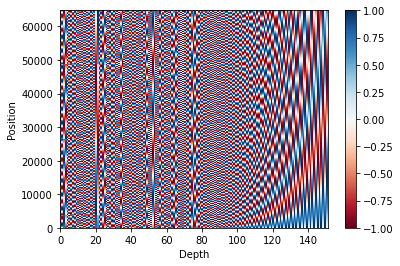

In [11]:
time_dim      = 151
total_seconds = 18*3600 # 18hours
pos_encoding  = positional_encoding(total_seconds, time_dim)
print(pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, time_dim))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [12]:
class BusNet(tf.keras.Model):
    def __init__(self, **kwargs):
        super(BusNet, self).__init__(**kwargs)

        self.week          = [i for i in range(0, 7) ]
        self.hours         = [i for i in range(0, 24)]
        self.minutes       = [i for i in range(0, 60)]
        self.seconds       = [i for i in range(0, 60)]
        
        
        self.time_dim      = 151 # 7 days + 24 hours + 60 minutes + 60 seconds
        self.time_count    = 18*3600

        self.bus_dim       = 32
        self.bus_count     = 1077

        self.route_dim     = 32
        self.route_count   = 353

        self.busstop_dim   = 32
        self.busstop_count = 1357

        self.dropout_rate  = 0.1

        self.days_of_week_matrix      = tf.one_hot(self.week   , len(self.week)   )
        self.hours_of_day_matrix      = tf.one_hot(self.hours  , len(self.hours)  )
        self.minutes_of_hour_matrix   = tf.one_hot(self.minutes, len(self.minutes))
        self.seconds_of_minute_matrix = tf.one_hot(self.seconds, len(self.seconds))
        self.time_position_matrix     = positional_encoding(self.time_count, self.time_dim)
        
        self.day_embedding     = tf.keras.layers.Embedding(len(self.week)    , len(self.week)   , weights=[self.days_of_week_matrix      ], trainable=False)
        self.hour_embedding    = tf.keras.layers.Embedding(len(self.hours)   , len(self.hours)  , weights=[self.hours_of_day_matrix      ], trainable=False)
        self.minute_embedding  = tf.keras.layers.Embedding(len(self.minutes) , len(self.minutes), weights=[self.minutes_of_hour_matrix   ], trainable=False)
        self.second_embedding  = tf.keras.layers.Embedding(len(self.seconds) , len(self.seconds), weights=[self.seconds_of_minute_matrix ], trainable=False)
        self.time_embedding    = tf.keras.layers.Embedding(self.time_count   , self.time_dim    , weights=[self.time_position_matrix[0]  ], trainable=True )
        self.bus_embedding     = tf.keras.layers.Embedding(self.bus_count    , self.bus_dim     , embeddings_initializer='uniform')
        self.route_embedding   = tf.keras.layers.Embedding(self.route_count  , self.route_dim   , embeddings_initializer='uniform')
        self.busstop_embedding = tf.keras.layers.Embedding(self.busstop_count, self.busstop_dim , embeddings_initializer='uniform')

        self.layer_1      = tf.keras.layers.Dense(100, activation='relu')
        #self.dropout_1    = tf.keras.layers.Dropout(self.dropout_rate)
        self.layer_2      = tf.keras.layers.Dense(64 , activation='relu')
        self.dropout_2    = tf.keras.layers.Dropout(self.dropout_rate)
        self.layer_3      = tf.keras.layers.Dense(32 , activation='relu')
        self.dropout_3    = tf.keras.layers.Dropout(self.dropout_rate)
        self.output_layer = tf.keras.layers.Dense(1)

    def call(self, inputs, training=True):
        # 'DAY_OF_WEEK', 'HOUR_OF_DAY', 'MINUTE_OF_HOUR', 'SECOND_OF_MINUTE', 'TIME',
        # 'BUS_ID', 'BUSROUTE_ID', 'BUSSTOP_ID', 'ROUTE_TIME', 'SEQ_NUM'
        days_of_week      = inputs[:, 0]
        hours_of_day      = inputs[:, 1]
        minutes_of_hour   = inputs[:, 2]
        seconds_of_minute = inputs[:, 3]
        time_positions    = inputs[:, 4]
        bus_ids           = inputs[:, 5]
        route_ids         = inputs[:, 6]
        busstop_ids       = inputs[:, 7]
        route_times       = inputs[:, 8]
        seq_nums          = inputs[:, 9]

        day_vectors     = self.day_embedding    (tf.cast(days_of_week     , dtype=tf.int32))
        hour_vectors    = self.hour_embedding   (tf.cast(hours_of_day     , dtype=tf.int32))
        minute_vectors  = self.minute_embedding (tf.cast(minutes_of_hour  , dtype=tf.int32))
        second_vectors  = self.second_embedding (tf.cast(seconds_of_minute, dtype=tf.int32))
        time_vectors    = self.time_embedding   (tf.cast(time_positions   , dtype=tf.int32))
        
        bus_vectors     = self.bus_embedding    (tf.cast(bus_ids    , dtype=tf.int32))
        route_vectors   = self.route_embedding  (tf.cast(route_ids  , dtype=tf.int32))
        busstop_vectors = self.busstop_embedding(tf.cast(busstop_ids, dtype=tf.int32))
        
        temporal_features =  tf.math.add(
            tf.concat([day_vectors, hour_vectors, minute_vectors, second_vectors], 1),
            time_vectors
        )
        #print(temporal_features.shape)

        concatted_input = tf.concat([
            temporal_features, 
            bus_vectors      , 
            route_vectors    , 
            busstop_vectors
        ], 1)
        #print(concatted_input.shape)
        
        x = self.layer_1(concatted_input)
        #print(x.shape)
        x = tf.concat([
            x, 
            tf.reshape(route_times, [route_times.shape[0], 1]),
            tf.reshape(seq_nums   , [seq_nums.shape   [0], 1])
        ], 1) # scaling factor
        #print(x.shape)
        x = self.layer_2(x)
        x = self.dropout_2(x, training=training)
        x = self.layer_3(x)
        x = self.dropout_3(x, training=training)

        return self.output_layer(x)

In [13]:
t = tf.constant([
    [1, 2, 3],
    [2, 3, 4],
])
a = tf.constant([2, 3])
b = tf.constant([4, 5])
print(t.shape, a.shape, b.shape)
print(tf.reshape(a, [a.shape[0], 1]))

c = tf.concat([t, tf.reshape(a, [a.shape[0], 1]), tf.reshape(b, [b.shape[0], 1])], 1)
print(c)

(2, 3) (2,) (2,)
tf.Tensor(
[[2]
 [3]], shape=(2, 1), dtype=int32)
tf.Tensor(
[[1 2 3 2 4]
 [2 3 4 3 5]], shape=(2, 5), dtype=int32)


In [14]:
#del model
model = BusNet()
model(np.array([train_input.iloc[0].values]))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.38274637]], dtype=float32)>

In [15]:
loss_object    = tf.keras.losses.Huber()

#optimizer      = tf.keras.optimizers.Adam()
optimizer      = tf.keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=0.01, nesterov=True)

train_loss     = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.MeanAbsoluteError(name='train_accuracy')

test_loss      = tf.keras.metrics.Mean(name='test_loss')
test_accuracy  = tf.keras.metrics.MeanAbsoluteError(name='test_accuracy')

ckpt    = tf.train.Checkpoint(step=tf.Variable(1), optimizer=optimizer, net=model)
manager = tf.train.CheckpointManager(ckpt, './busnet_checkpoints', max_to_keep=3)

In [21]:
@tf.function
def train_step(input_batch, label_batch):
    with tf.GradientTape() as tape:
        predictions = model(input_batch, training=True)
        loss        = loss_object(label_batch, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    train_loss(loss)
    train_accuracy(label_batch, predictions)

In [17]:
@tf.function
def test_step(input_batch, label_batch):
    predictions = model(input_batch, training=False)
    t_loss      = loss_object(label_batch, predictions)
    test_loss(t_loss)
    test_accuracy(label_batch, predictions)

In [18]:
ckpt.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
    print("Restored from {}".format(manager.latest_checkpoint))
else:
    print("Initializing from scratch.")

Restored from ./busnet_checkpoints\ckpt-120


In [22]:
epochs     = 5
batch_size = 256

for epoch in range(0, epochs):
    train_loss.reset_states()
    train_accuracy.reset_states()
    print("starting of epoch", epoch)
    for step, (t_input, t_target) in enumerate(training_dataset.batch(batch_size)):
        train_step(tf.cast(t_input, dtype=tf.float32), t_target)
        if step % 200 == 0:
            print("epoch:", epoch, "step:", step, "training loss", float(train_loss.result()), "training accuracy", float(train_accuracy.result()))

        ckpt.step.assign_add(1)
        if int(ckpt.step) % 5000 == 0:
            save_path = manager.save()
            print("Saved checkpoint for step {}: {}".format(int(ckpt.step), save_path))
            
        if int(ckpt.step) % 5000 == 0:
            print("evaluating on test data...")
            test_loss.reset_states()
            test_accuracy.reset_states()
            for t_step, (t_input, t_target) in enumerate(testing_dataset.shuffle(buffer_size=250).batch(256)):
                test_step(tf.cast(t_input, dtype=tf.float32), t_target)
                #if t_step%40==0 and t_step!=0:
                #    break
            print("test data result => testing loss", float(test_loss.result()), "testing accuracy", float(test_accuracy.result()))
            print("back to training...")
    print(epoch, "is done.")

starting of epoch 0
epoch: 0 step: 0 training loss 672.4026489257812 training accuracy 672.90234375
Saved checkpoint for step 1110000: ./busnet_checkpoints\ckpt-222
evaluating on test data...
test data result => testing loss 162.17691040039062 testing accuracy 162.81723022460938
back to training...
epoch: 0 step: 200 training loss 95.23672485351562 training accuracy 95.73277282714844
epoch: 0 step: 400 training loss 95.53731536865234 training accuracy 96.03336334228516
epoch: 0 step: 600 training loss 82.71302032470703 training accuracy 83.20892333984375
epoch: 0 step: 800 training loss 76.15454864501953 training accuracy 76.65017700195312
epoch: 0 step: 1000 training loss 76.79769897460938 training accuracy 77.29336547851562
epoch: 0 step: 1200 training loss 85.78805541992188 training accuracy 86.28382873535156
epoch: 0 step: 1400 training loss 82.88955688476562 training accuracy 83.38536834716797
epoch: 0 step: 1600 training loss 78.19792938232422 training accuracy 78.69363403320312


epoch: 1 step: 5400 training loss 59.3509635925293 training accuracy 59.845672607421875
epoch: 1 step: 5600 training loss 58.92814254760742 training accuracy 59.42286682128906
epoch: 1 step: 5800 training loss 58.3829460144043 training accuracy 58.87770462036133
epoch: 1 step: 6000 training loss 58.80262756347656 training accuracy 59.29738235473633
epoch: 1 step: 6200 training loss 58.7279167175293 training accuracy 59.22267150878906
epoch: 1 step: 6400 training loss 58.72248840332031 training accuracy 59.21726989746094
epoch: 1 step: 6600 training loss 58.772708892822266 training accuracy 59.26741027832031
epoch: 1 step: 6800 training loss 58.45756912231445 training accuracy 58.95226287841797
epoch: 1 step: 7000 training loss 58.79103469848633 training accuracy 59.28574752807617
epoch: 1 step: 7200 training loss 58.36840057373047 training accuracy 58.8631477355957
epoch: 1 step: 7400 training loss 57.889041900634766 training accuracy 58.383827209472656
epoch: 1 step: 7600 training los

epoch: 2 step: 11200 training loss 58.6142578125 training accuracy 59.10904312133789
2 is done.
starting of epoch 3
epoch: 3 step: 0 training loss 666.7909545898438 training accuracy 667.286865234375
epoch: 3 step: 200 training loss 90.59825897216797 training accuracy 91.09407043457031
epoch: 3 step: 400 training loss 91.48578643798828 training accuracy 91.98155975341797
epoch: 3 step: 600 training loss 79.04747772216797 training accuracy 79.54304504394531
epoch: 3 step: 800 training loss 72.2393798828125 training accuracy 72.73468017578125
epoch: 3 step: 1000 training loss 72.985107421875 training accuracy 73.48026275634766
epoch: 3 step: 1200 training loss 81.6735610961914 training accuracy 82.16893768310547
Saved checkpoint for step 1145000: ./busnet_checkpoints\ckpt-229
evaluating on test data...
test data result => testing loss 164.29505920410156 testing accuracy 164.5140380859375
back to training...
epoch: 3 step: 1400 training loss 79.1152114868164 training accuracy 79.610565185

epoch: 4 step: 5200 training loss 58.24746322631836 training accuracy 58.741859436035156
epoch: 4 step: 5400 training loss 57.59806823730469 training accuracy 58.09239196777344
epoch: 4 step: 5600 training loss 57.1786003112793 training accuracy 57.67295837402344
epoch: 4 step: 5800 training loss 56.657997131347656 training accuracy 57.15237808227539
epoch: 4 step: 6000 training loss 57.12558364868164 training accuracy 57.6199836730957
epoch: 4 step: 6200 training loss 57.042640686035156 training accuracy 57.537078857421875
epoch: 4 step: 6400 training loss 57.0512580871582 training accuracy 57.54570007324219
epoch: 4 step: 6600 training loss 57.14470672607422 training accuracy 57.639102935791016
epoch: 4 step: 6800 training loss 56.82513427734375 training accuracy 57.31953048706055
epoch: 4 step: 7000 training loss 57.11189651489258 training accuracy 57.60634231567383
epoch: 4 step: 7200 training loss 56.71715545654297 training accuracy 57.21161651611328
epoch: 4 step: 7400 training l